In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import lifetimes as lf
from lifetimes.plotting import plot_probability_alive_matrix

# Load the dataset
df = pd.read_csv(r'data\transaction_data.csv')

# Display info about the DataFrame
df.info()

# Filter out rows where UserId is -1
df = df[df['UserId'] != -1]


df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])
df['SalesValue'] = df['NumberOfItemsPurchased'] * df['CostPerItem']



# Ensure 'TransactionTime' is a datetime column
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

# Resampling by month and summing 'SalesValue'
df_resampled = df.resample('M', on='TransactionTime')['SalesValue'].sum().reset_index()

df_resampled.head()



# Filtering the data between specific dates
df_filtered = df_resampled[(df_resampled['TransactionTime'] >= '2018-01-01') & (df_resampled['TransactionTime'] <= '2019-04-01')]
last_date = df_filtered['TransactionTime'].max()
df_filtered.head()
last_date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083818 entries, 0 to 1083817
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   UserId                  1083818 non-null  int64  
 1   TransactionId           1083818 non-null  int64  
 2   TransactionTime         1083818 non-null  object 
 3   ItemCode                1083818 non-null  int64  
 4   ItemDescription         1080910 non-null  object 
 5   NumberOfItemsPurchased  1083818 non-null  int64  
 6   CostPerItem             1083818 non-null  float64
 7   Country                 1083818 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 66.2+ MB


Timestamp('2019-03-31 00:00:00')

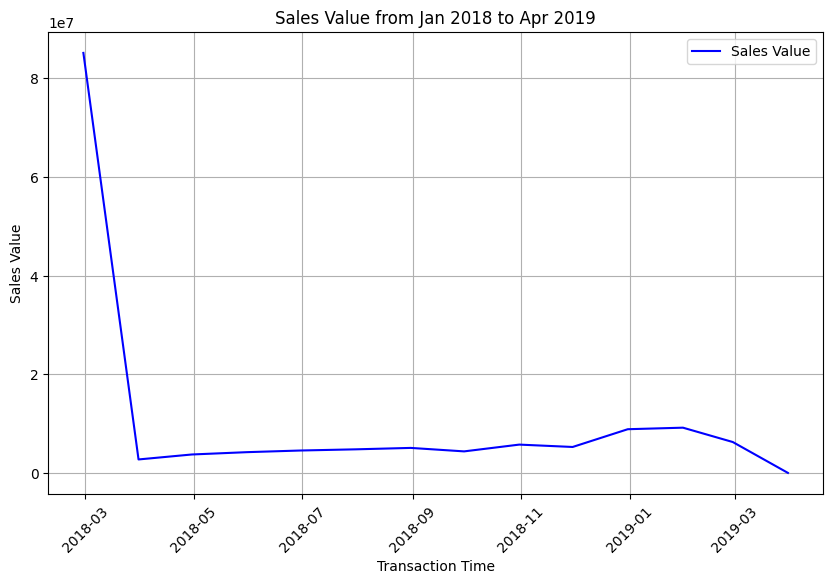

In [3]:

# Plotting the sales values
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['TransactionTime'], df_filtered['SalesValue'], label='Sales Value', color='blue')
plt.title('Sales Value from Jan 2018 to Apr 2019')
plt.xlabel('Transaction Time')
plt.ylabel('Sales Value')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [4]:

# Create a summary DataFrame from the original dataset (not the resampled one)
summary_df = lf.utils.summary_data_from_transaction_data(
    df,  # Use the original dataset for summary
    customer_id_col='UserId', 
    datetime_col='TransactionTime', 
    monetary_value_col='SalesValue',
    observation_period_end=last_date
)

# Display the summary DataFrame
print(summary_df.head())


        frequency  recency      T  monetary_value
UserId                                           
259266        0.0      0.0  364.0           0.000
259287        5.0    315.0  356.0        5182.488
259308        3.0    283.0  397.0        2512.800
259329        0.0      0.0   57.0           0.000
259350        0.0      0.0  349.0           0.000


In [5]:
summary_df = summary_df[summary_df['monetary_value'] > 0]


In [6]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.15)
#The BG/NBD model is used to predict the number of repeat purchases a customer will make in the future.
# The penalizer coefficient (penalizer_coef=0.15) is included to regularize the model and prevent overfitting.
# If the model doesn’t converge, increasing the penalizer coefficient might help.

In [7]:
bgf.fit(summary_df['frequency'], summary_df['recency'], summary_df['T'])
#the fit() method trains the BG/NBD model. It uses the following columns:
#frequency: Number of repeat purchases made by the customer.
#recency: Time between the customer’s first and most recent purchase.
#T: The duration for which the customer has been observed (from their first purchase to the end of the observation period)
print(bgf.summary)


            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.875652  0.018962         0.838486         0.912818
alpha  46.520372  1.506709        43.567222        49.473522
a       0.018592  0.003410         0.011909         0.025276
b       0.222917  0.026192         0.171581         0.274254


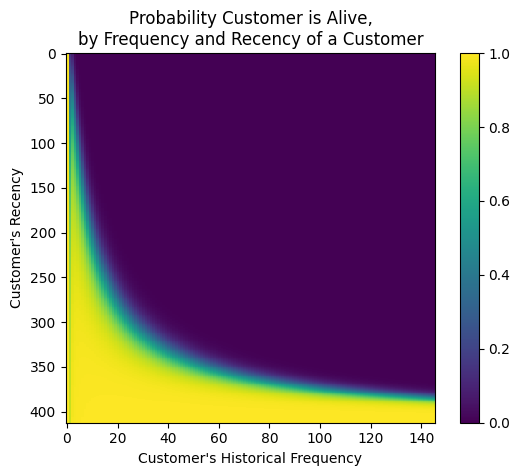

In [8]:
plot_probability_alive_matrix(bgf)
plt.show()

In [9]:
#his plot shows the probability that a customer is still "alive" (i.e., has not churned) based on their recency and frequency using the BG/NBD model.
'''
Explanation:
X-axis (Customer’s Historical Frequency):

This represents how many repeat purchases the customer has made historically.
As frequency increases, it generally indicates a more engaged customer.
Y-axis (Customer’s Recency):

This represents how recently the customer made a purchase.
Higher values mean the customer hasn't made a purchase for a long time, while lower values indicate recent purchases.
Color Scale (Probability of Being Alive):

The color gradient represents the probability that a customer is still "alive" and will make repeat purchases in the future.
Yellow (1.0): High probability of the customer still being active.
Purple (0.0): Low probability of the customer still being active (i.e., more likely to have churned).
Insights:
Customers with low recency (recent purchasers) and high frequency (frequent buyers) are very likely to still be "alive" and continue making purchases (yellow area in the bottom right).
Customers with high recency (haven't purchased in a long time) and low frequency (few purchases) are less likely to make another purchase (purple area in the top left).'''

'\nExplanation:\nX-axis (Customer’s Historical Frequency):\n\nThis represents how many repeat purchases the customer has made historically.\nAs frequency increases, it generally indicates a more engaged customer.\nY-axis (Customer’s Recency):\n\nThis represents how recently the customer made a purchase.\nHigher values mean the customer hasn\'t made a purchase for a long time, while lower values indicate recent purchases.\nColor Scale (Probability of Being Alive):\n\nThe color gradient represents the probability that a customer is still "alive" and will make repeat purchases in the future.\nYellow (1.0): High probability of the customer still being active.\nPurple (0.0): Low probability of the customer still being active (i.e., more likely to have churned).\nInsights:\nCustomers with low recency (recent purchasers) and high frequency (frequent buyers) are very likely to still be "alive" and continue making purchases (yellow area in the bottom right).\nCustomers with high recency (haven\

In [10]:
import numpy as np  # Ensure you import numpy

summary_df['predicted_purchases_90'] = np.floor(bgf.conditional_expected_number_of_purchases_up_to_time(
    t=90,  # For the next 90 days
    frequency=summary_df['frequency'], 
    recency=summary_df['recency'], 
    T=summary_df['T']
)).astype(int)
summary_df['predicted_purchases_oneyear'] = np.floor(bgf.conditional_expected_number_of_purchases_up_to_time(
    t=360,  # For the next 90 days
    frequency=summary_df['frequency'], 
    recency=summary_df['recency'], 
    T=summary_df['T']
)).astype(int)   # Convert to integer

# Displaying the first few rows
print(summary_df[['frequency', 'recency', 'T', 'predicted_purchases_90','predicted_purchases_oneyear']].head())



        frequency  recency      T  predicted_purchases_90  \
UserId                                                      
259287        5.0    315.0  356.0                       1   
259308        3.0    283.0  397.0                       0   
259392        6.0    260.0  335.0                       1   
259476        2.0    303.0  364.0                       0   
259518        1.0    149.0  189.0                       0   

        predicted_purchases_oneyear  
UserId                               
259287                            5  
259308                            3  
259392                            6  
259476                            2  
259518                            2  


In [11]:
# Export summary_df to a CSV file
summary_df.to_csv('summary_features.csv', index=False)
